In [1]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt

import numpy as np
from statistics import mean
import random
random.seed(12345)
np.random.seed(12345)

plt.rcParams["font.family"] = "serif"
plt.rcParams["savefig.dpi"] = 150

def newfigure():
    plt.figure()
    plt.tick_params(direction='in', grid_linestyle=":", top=True, right=True)
    plt.grid(which='major', axis='both', linestyle=":")

# 1. Initial investigation

Firstly, using the output of the first subsystem, we can model the physical behaviour of the lift in order to determine travel times between floors.

Since the lift is being modelled with constant, or zero, acceleration/deceleration, we can fully derive these characteristics. The result of which has been coded into the `subsystem.py` python file.

The lift characteristics have been instantiated with fairly arbritrary parameters. This is in order to decouple the subsystem from subsystem 1. The main difference of altering these parameters is the required distance/time in order for a lift to reach maximum velocity.

The distance required to reach maximum velocity:     16.0
Number of floors required to reach maximum velocity:  4.0
The time taken to reach maximum velocity:             8.0

travel_time(n) calculates total time taken (seconds) to travel n integer floors this included closing of the doors and opening at the destination.
        
        

n =  1    Travel = 11.657 seconds
n =  2    Travel = 14.000 seconds
n =  3    Travel = 15.798 seconds
n =  4    Travel = 17.314 seconds
n =  5    Travel = 18.649 seconds


<IPython.core.display.Javascript object>


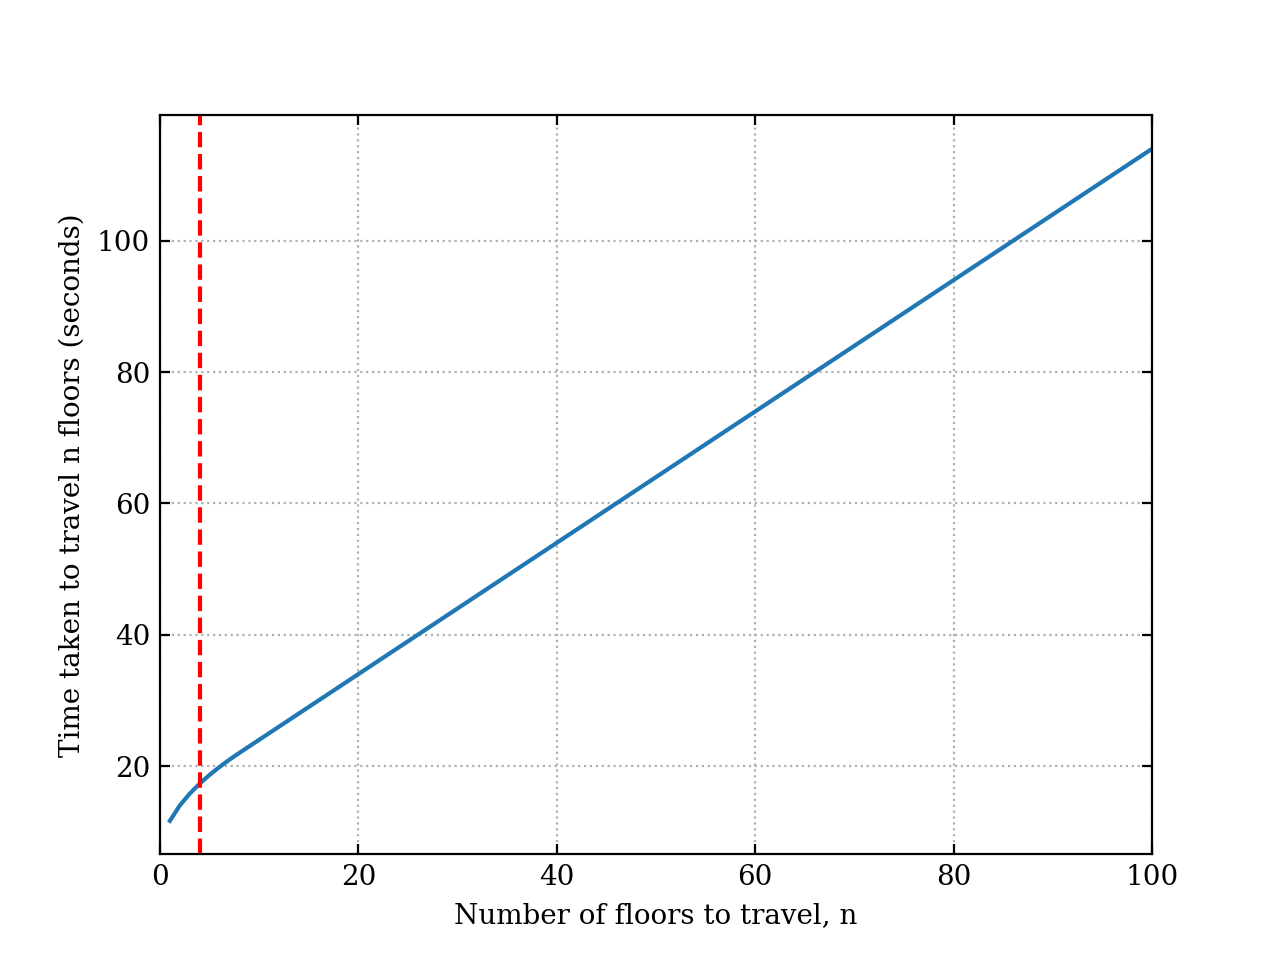

In [3]:
import subsystem2 # import relevant, abstracted code

lift = subsystem2.Lift(vmax = 4.0, 
                      acc  = 0.5, 
                      door_time    = 3.0,
                      floor_height = 4.0)

print("The distance required to reach maximum velocity:     {:4}".format(lift.smv))
print("Number of floors required to reach maximum velocity: {:4}".format(lift.smv/lift.df))
print("The time taken to reach maximum velocity:            {:4}".format(lift.tmv))

print("\n"+lift.travel_time.__doc__+"\n")

nfloors = 100
ns = range(1, nfloors+1)
Ts = []
    
for n in ns:
    t = lift.travel_time(n)
    Ts.append(t)
    if n < 6:
        print("n = {0:2d}    Travel = {1:6.3f} seconds".format(n,t))


newfigure()
plt.plot(ns, Ts)
plt.axvline(x=lift.smv/lift.df, linestyle="--", color="red")
plt.ylabel("Time taken to travel n floors (seconds)")
plt.xlabel("Number of floors to travel, n")
plt.xlim(0, nfloors)
plt.show()
plt.savefig('output/floorsvtime.png')

The graph shows that beyond the threshold of reaching maximum velocity, the change in travel time simply scales linearly, as expected.

# Challenging Assumptions

A natural assumption 

Next, comparing the travel time of a lift going to floors spread out vs travel further and do consecutive floors:

<IPython.core.display.Javascript object>


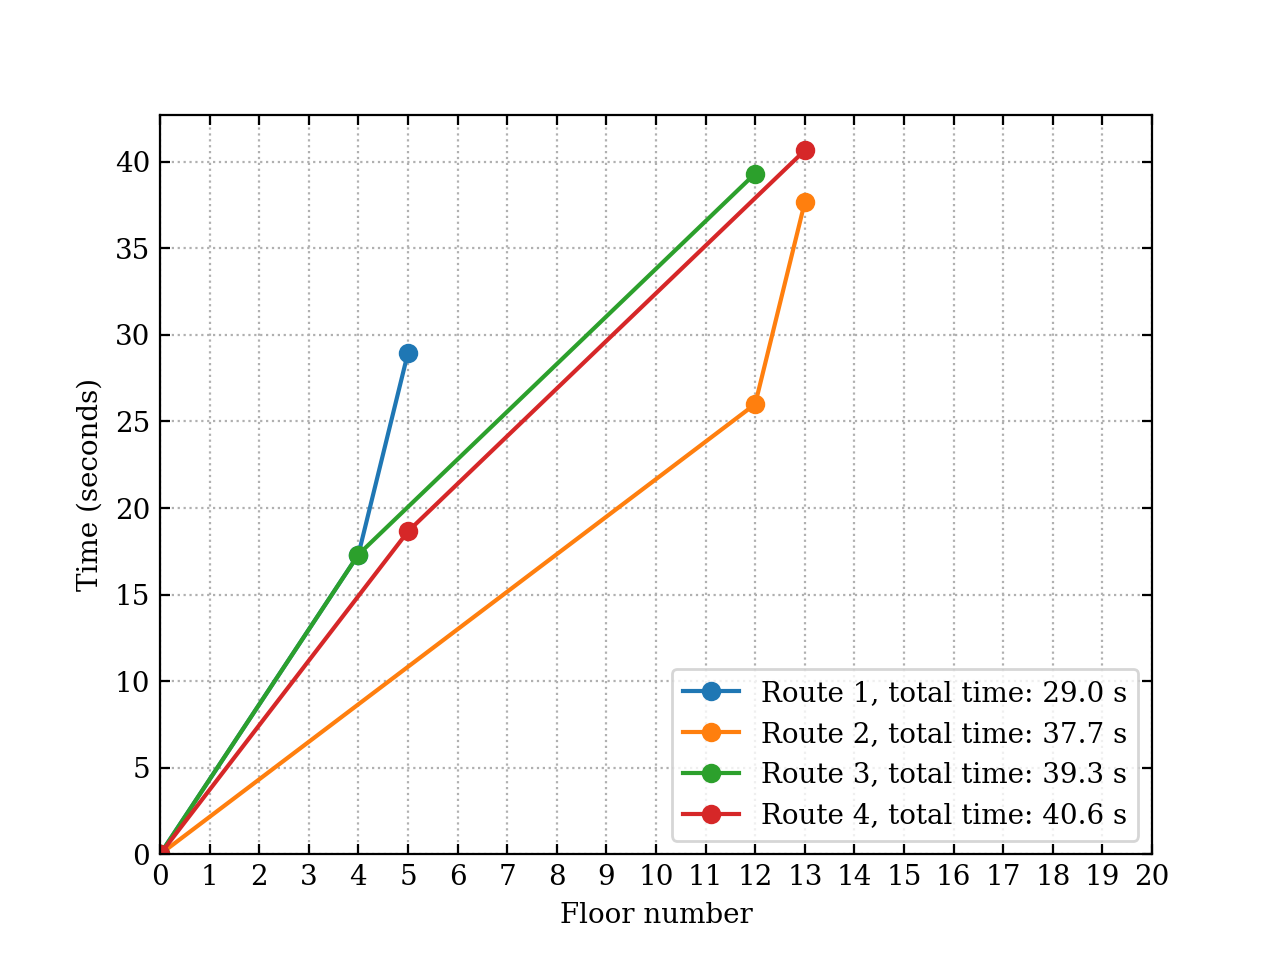

Route 1: 28.97 sec with average travel time 15.43 sec
Route 2: 37.66 sec with average travel time 21.22 sec
Route 3: 39.31 sec with average travel time 18.88 sec
Route 4: 40.65 sec with average travel time 19.77 sec
Average time of route 1 & 2: 27.485 sec
Average time of route 3 & 4: 28.981 sec


In [4]:
# routes = [[0,  5, 10, 15, 20],
#           [0, 17, 18, 19, 20],
#           [0,  1,  3, 19, 20]]

routes = [[0,  4,  5],
          [0, 12, 13],
          [0,  4, 12],
          [0,  5, 13]]

rct = [lift.comp_travel(r) for r in routes]
llabels = []

route_passenger_times = []

newfigure()

for i, r in enumerate(routes):
    
    rct = lift.comp_travel(r)
    route_passenger_times.append(rct[1:])
    print("Route {:d}: {:5.2f} sec with average travel time {:.2f} sec".format(i+1, rct[-1], np.mean(rct)))
    
    plt.plot(r, rct, '-o')
    llabels.append("Route {:}, total time: {:.1f} s".format(i+1, rct[-1]))

plt.ylabel("Time (seconds)")
plt.xlabel("Floor number")
plt.xticks(range(0, 21))
plt.xlim(0,20)
plt.ylim(0)
plt.legend(llabels)
plt.show()
plt.savefig('output/comp_travel.png')

print("Average time of route 1 & 2: {:.3f} sec".format(np.mean(route_passenger_times[0:2])))
print("Average time of route 3 & 4: {:.3f} sec".format(np.mean(route_passenger_times[2:])))

This graph showed us that bundling destination floors together can actually result in a lower average travel time per user. Additionally, for future use, *route 1* would result in an lift becoming significantly faster than any alternative.

# Testing a greed allocation algorithm

- Pass in a list of users, represented as their destination floor number.
- The arrive through a single allocation keypad.
- There will be 20 users, each going to a different random floor from a 30 storey building

- Now I'll try to pass in a list of users, represented as the floor number they want to go to. 
- They arrive in an order and enter their floor one by one so a list is suitable input.
- The first list of users will be a group of 20, each wanting to go to a different floor in a 30 story building.
- Each lift will take one user at a time.
- Greedy algorithm will assign to first available lift.


In [5]:
n_users = 20
n_floors = 30
n_lifts = 8

users = list(range(1,n_floors+1))

print("Created a list of {:} users".format(len(users)))
print("Removing {} users from the list".format(n_floors-n_users))

for i in range(n_floors-n_users):
    randuser = random.randint(0, len(users)-1)
    del users[randuser]

print("Shuffling order of the users".format(len(users)))
random.shuffle(users)
print(users)

# create the lift struct
lifts = []
for l in range(n_lifts):
  lifts.append([])

# assign each user to lifts
lift_id = 0
for user in users:
  lifts[lift_id].append(user)
  lift_id = (lift_id+1) % len(lifts)


total_time = 0
lift_times = []
lift_avgs = []
  
print("\nLifts went to the following floors:")
for i, users in enumerate(lifts):
    t = 0
    liftq = users.copy()
    while len(liftq) > 0:
        user = liftq.pop(0)
        waiters = len(liftq)    
        travel = lift.travel_time(user)
        t += travel + 2*waiters*lift.travel_time(user)
  
    lift_times.append(t)
    lift_avgs.append(t/len(users))
    print("  Lift {0:} traveled for {2:4.0f} seconds, with average user time of {3:3.0f} secs/user, and went to floors: {1:}".format(i, users, t, t/len(users)))

total_time = sum(lift_times)
print("\nTotal travel time {:.0f} sec with an average travel time of {:.0f} sec/user".format(total_time, mean(lift_avgs)))

Created a list of 30 users
Removing 10 users from the list
Shuffling order of the users
[3, 21, 19, 23, 2, 9, 10, 27, 24, 22, 16, 4, 17, 13, 6, 28, 5, 18, 7, 20]

Lifts went to the following floors:
  Lift 0 traveled for  212 seconds, with average user time of  71 secs/user, and went to floors: [3, 24, 5]
  Lift 1 traveled for  315 seconds, with average user time of 105 secs/user, and went to floors: [21, 22, 18]
  Lift 2 traveled for  276 seconds, with average user time of  92 secs/user, and went to floors: [19, 16, 7]
  Lift 3 traveled for  271 seconds, with average user time of  90 secs/user, and went to floors: [23, 4, 20]
  Lift 4 traveled for   73 seconds, with average user time of  36 secs/user, and went to floors: [2, 17]
  Lift 5 traveled for   96 seconds, with average user time of  48 secs/user, and went to floors: [9, 13]
  Lift 6 traveled for   92 seconds, with average user time of  46 secs/user, and went to floors: [10, 6]
  Lift 7 traveled for  165 seconds, with average u

# Modelling passenger arrival

Papers discuss modelling passenger arrival as compound poisson distribution.

In [6]:
# 9 am
nine = 9*60*60
tenmin = 10*60
print("9 am is t= {}".format(nine))
print("10 min period is t= {}".format(tenmin))
print(60*60*2)

9 am is t= 32400
10 min period is t= 600
7200


<IPython.core.display.Javascript object>


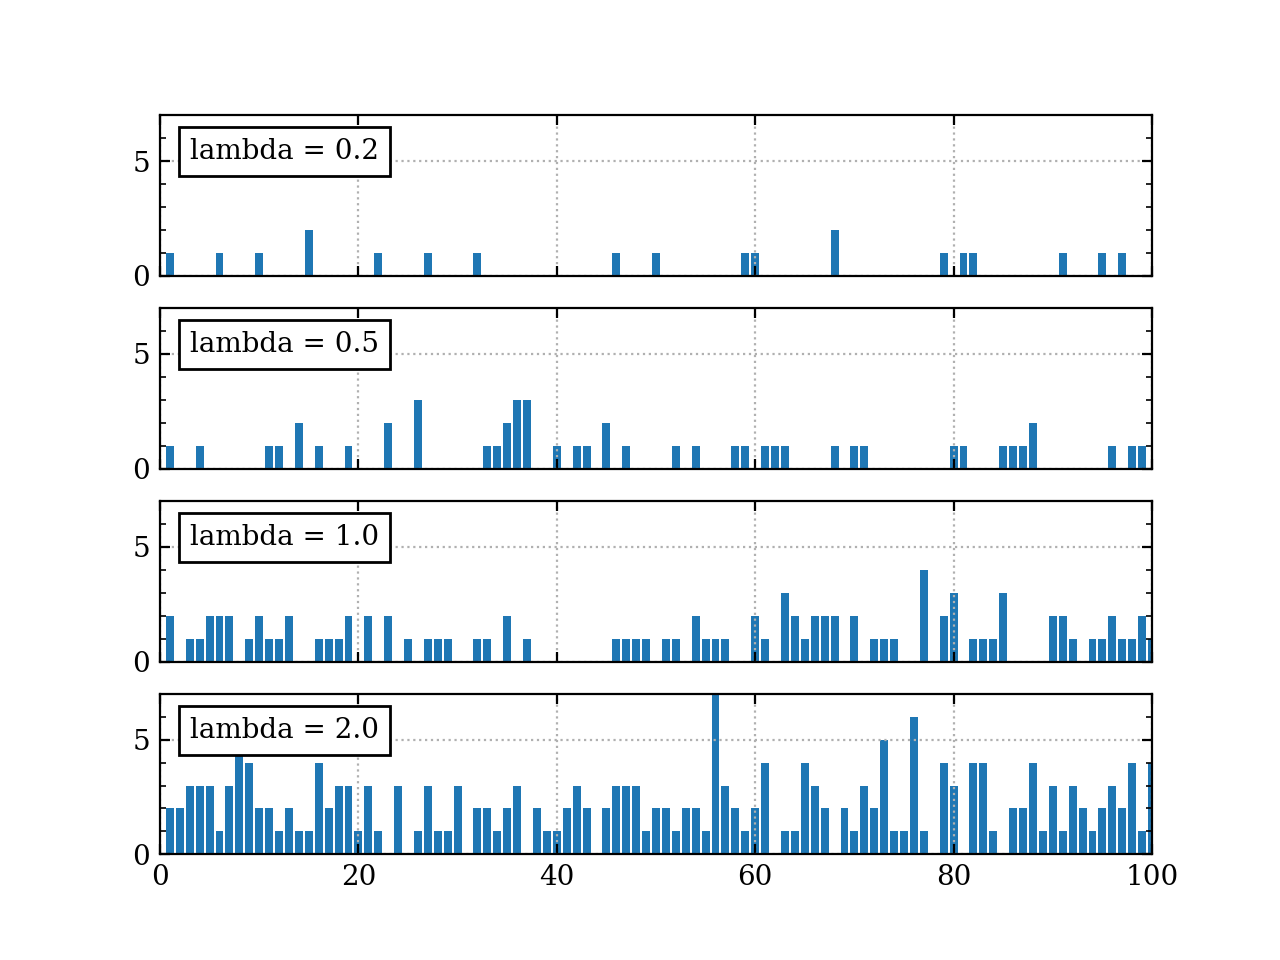

<IPython.core.display.Javascript object>


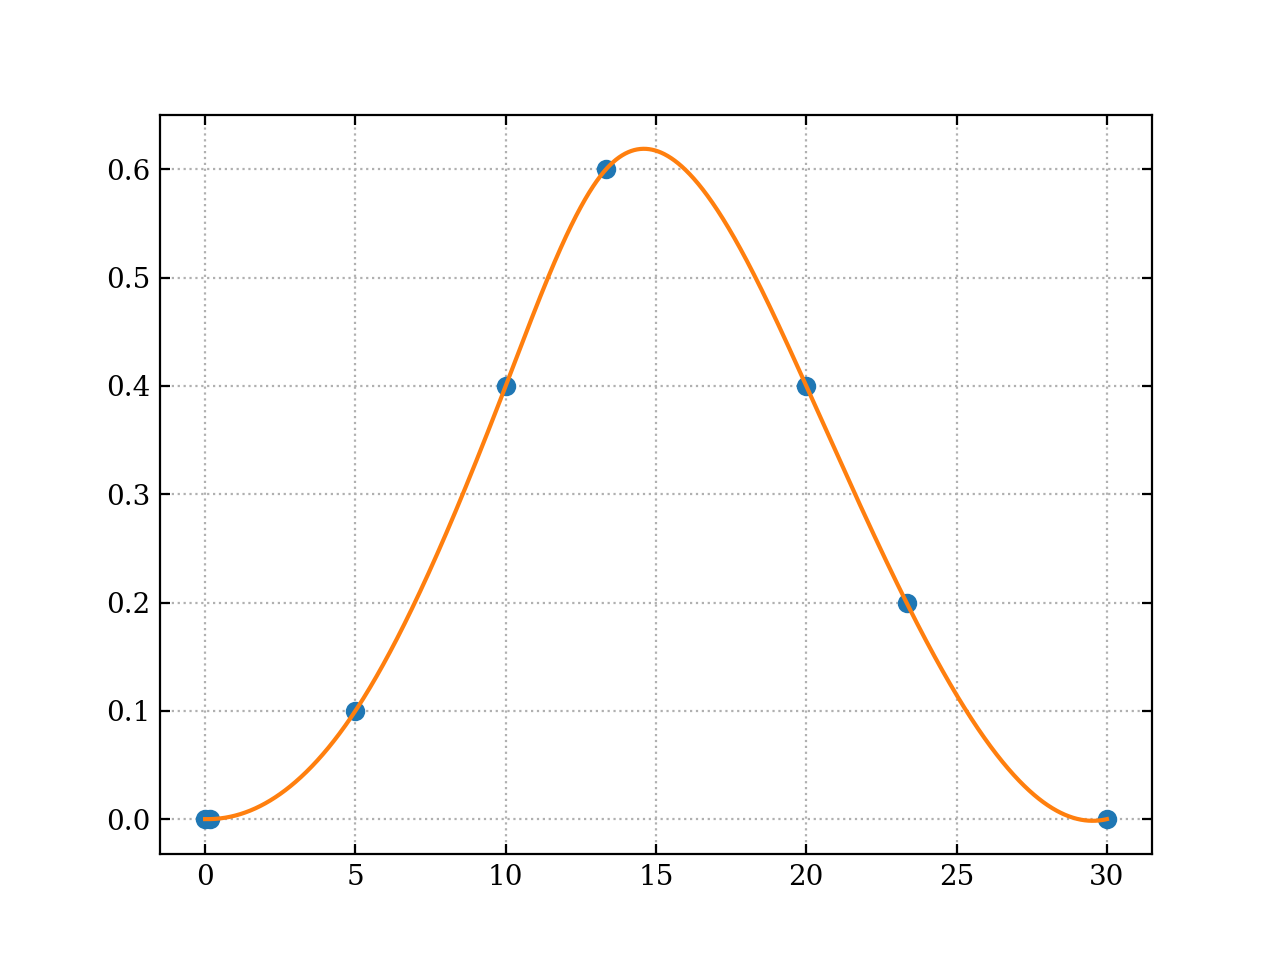

In [7]:
lams = [0.2, 0.5, 1.0, 2.0]
pds = [np.random.poisson(lam=l, size=100) for l in lams]
fig, axarr = plt.subplots(len(lams), sharex=True)
for i, l in enumerate(lams):
    axarr[i].bar(np.arange(1,len(pds[i])+1), pds[i])
    
    m = np.amax(pds)
    axarr[i].set_xlim(0,100)
    axarr[i].set_ylim(0,m)
    axarr[i].set_yticks(np.arange(0,m,1), minor=True)
    
    axarr[i].tick_params(which='both', direction='in', grid_linestyle=":", top=True, right=True)
    axarr[i].grid(which='major', axis='both', linestyle=":")
    axarr[i].text(3, np.amax(pds)-1, 'lambda = {}'.format(l), verticalalignment='top', bbox={'facecolor':'white'})

fig.savefig('output/poisson_comparison.png')


# from scipy.stats import norm
# x = np.linspace(0, 7200, 7200)
# newfigure()
# plt.plot(x, norm.pdf(x, 4000, 800))


from scipy.interpolate import interp1d

xf = [0,10,300,600,800,1200,1400,1800]
yf = [0,0,0.1,0.4,0.6,0.4,0.2,0]

f = interp1d(xf, yf, kind='cubic')

xnew = np.linspace(0, 1800, num=1800)

newfigure()
plt.plot(xf, yf, 'o', xnew, f(xnew), '-')
# plt.legend(['data', 'linear', 'cubic'], loc='best')

xtn = range(0,1801,60*5)
xtl = range(0,math.ceil(1801/60),1*5)
plt.xticks(xtn,xtl)
plt.show()

# Lift System OOP

In [8]:
from pprint import pprint

floors = 100
lift_capacity = 8
clock = 0

capacity_threshold = 0.8

class Lift:
  def __init__(self, id, capacity):
    self.id = id
    self.available = True
    self.capacity = capacity
    self.arrival_time = None
    self.passengers = []
  
  def update(self, clock):
    if self.available:
      self.check_departure(clock)
    else:
      self.check_arrival(clock)
    
  
  def check_departure(self, clock):
    if len(self.passengers) >= capacity_threshold*self.capacity:
      
      self.available = False # leaving lobby so cannot accept passengers
      rtt = self.trip_times() # update trip times for all passengers and return RTT for lift
      self.arrival_time = math.ceil(clock + rtt) # set when lift will next be available in the lobby
      
      print("Lift {} is departing. RTT = {} ETA: {}".format(self.id, rtt, self.arrival_time))
            
      
  def check_arrival(self, current_time):
    if current_time == self.arrival_time: 
      print("Lift {} is arriving.".format(self.id))
      for p in self.passengers:
        completed_travellers.append(p)
      self.passengers = []
      self.available = True
      print("Lift {} has arrived and available to use.".format(self.id))
        
  def available(self):
    return self.available
    
  def trip_times(self):
   
    # sort the passengers in order of request
    self.passengers = sorted(self.passengers, key=lambda d: d['floor'])

    time = 0
    times = []
    prev_n = 0
    for p in self.passengers:
      n = p['floor']
      time += T(n-prev_n)
      p['travel_time'] = time
      prev_n = n
    return time
  
  def add_passenger(self, passenger):
    if len(self.passengers) < self.capacity and self.available:
      self.passengers.append(passenger)
      print("Lift {} just added passenger going to floor {}".format(self.id, passenger['floor']))
      return True
    else:
      return False

  
  
  
  
  
  
# create a random list of passengers, one will arrive each second

traffic = np.random.randint(1, floors+1, 200).tolist()
print(traffic)

completed_travellers = []

q = []
lifts = [Lift(i, lift_capacity) for i in range(5)]






while clock < 60*15:
#   print(clock)
  
  # new arrivals to the queue
  if len(traffic) > 0:
    q.append({
        "floor": traffic.pop(0),
        "arrival_time": clock
    })
 
  
  # update departure/arrival for all lifts
  for lift in lifts:
    lift.update(clock)
    
  # ASSIGN PEOPLE IN Q TO A LIFT ------------------------------------
  
  while len(q) > 0:
    person = q.pop(0)
    
    # check each lift in turn for availability
    for lift in lifts:
      if lift.add_passenger(person):
        break # stop checking lifts
      else:
        pass # check the next lift in the list
  
  # ASSIGNMENT OVER -------------------------------------------------
  
  if len(q) > 0:
    print("There are people waiting for a lift!")
  
  clock += 1

# print(lobby)
# for lift in lifts:
#   print(lift.id)
pprint(completed_travellers)
  

[93, 84, 78, 99, 25, 43, 60, 63, 88, 33, 65, 44, 1, 8, 4, 48, 30, 39, 46, 80, 33, 48, 54, 82, 7, 69, 75, 68, 13, 13, 85, 47, 14, 33, 96, 13, 3, 94, 91, 41, 76, 83, 28, 52, 43, 86, 90, 18, 84, 70, 46, 41, 99, 90, 74, 60, 67, 1, 34, 49, 93, 46, 52, 46, 82, 8, 61, 23, 31, 30, 91, 19, 38, 95, 48, 76, 55, 85, 6, 21, 36, 8, 65, 49, 15, 42, 50, 44, 98, 42, 5, 49, 70, 79, 86, 25, 18, 38, 28, 99, 52, 46, 67, 55, 37, 15, 55, 95, 97, 99, 18, 46, 63, 54, 48, 45, 95, 60, 89, 21, 5, 60, 51, 63, 34, 39, 5, 94, 93, 65, 3, 37, 65, 82, 2, 69, 54, 78, 58, 28, 88, 85, 1, 20, 17, 46, 30, 21, 45, 84, 90, 22, 11, 1, 62, 66, 88, 51, 10, 76, 46, 89, 81, 36, 64, 61, 20, 73, 41, 26, 39, 51, 58, 38, 25, 85, 55, 47, 28, 44, 16, 97, 99, 95, 56, 57, 30, 81, 68, 18, 65, 75, 83, 33, 95, 97, 39, 62, 68, 70]
Lift 0 just added passenger going to floor 93
Lift 0 just added passenger going to floor 84
Lift 0 just added passenger going to floor 78
Lift 0 just added passenger going to floor 99
Lift 0 just added passenger goi

NameError: name 'T' is not defined

In [9]:
# Example code that definetly works for animating data in plot

# import numpy as np
# import matplotlib.pyplot as plt

# m = 100
# n = 100
# matrix = np.random.normal(0,1,m*n).reshape(m,n)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for i in range(0,100):
#     ax.clear()
#     ax.plot(matrix[i,:])
#     fig.canvas.draw()